<a href="https://colab.research.google.com/github/mgiorgi13/brain_tumor_classifier/blob/mattia/CNN_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In this paragraph, we have imported the necessary libraries to create the CNN. TensorFlow and Keras are the main frameworks that we will use to create the convolutional neural network. Additionally, we have imported other useful libraries such as OpenCV (cv2) for image preprocessing, PIL for image manipulation, and Matplotlib for image visualization.

In [20]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization
import os
import glob
import shutil
from sklearn.utils import shuffle
import zipfile
import cv2
import imutils
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn import metrics

In [13]:
dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# **Google Drive connection**

Necessary to run the classifier

In [5]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Load Dataset**

In [14]:
# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# Definisci le dimensioni delle immagini
image_size = 250
batch_size = 32

# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 4300 images belonging to 4 classes.
Found 1430 images belonging to 4 classes.
Found 1430 images belonging to 4 classes.


In [16]:
class_indices = test_generator.class_indices
num_samples = test_generator.samples

class_counts = {class_label: 0 for class_label in class_indices}

# Conta i campioni per ogni classe
for filename in val_generator.filenames:
    class_label = filename.split('/')[0]  # Ottieni l'etichetta della classe dal percorso del file
    class_counts[class_label] += 1

# Calcola la percentuale di campioni per ogni classe
class_balances = {class_label: count / num_samples for class_label, count in class_counts.items()}

print("Bilanciamento delle classi nel set di test:")
for class_label, balance in class_balances.items():
    print(f"Classe {class_label}: {balance * 100}%")


Bilanciamento delle classi nel set di test:
Classe glioma_tumor: 25.874125874125873%
Classe meningioma_tumor: 26.153846153846157%
Classe no_tumor: 22.797202797202797%
Classe pituitary_tumor: 25.174825174825177%


# **CNN from scratch**

In [ ]:
# Definire un modello sequenziale di Keras
model = Sequential()

# Aggiungere un layer convoluzionale con 32 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))

# Aggiungere un layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un altro layer convoluzionale con 64 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# Aggiungere un altro layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un altro layer convoluzionale con 128 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# Aggiungere un altro layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un layer di appiattimento per convertire l'output del layer precedente in un vettore unidimensionale
model.add(Flatten())

# Aggiungere un layer completamente connesso con 512 unità e funzione di attivazione ReLU
model.add(Dense(512, activation='relu'))

# Aggiungere un layer di dropout con una percentuale di dropout di 0,5
model.add(Dropout(0.5))

# Aggiungere un altro layer completamente connesso con 4 unità (una per ogni classe) e funzione di attivazione softmax
model.add(Dense(4, activation='softmax'))

# Stampa il riepilogo del modello
model.summary()


In [ ]:
# Compilare il modello con la funzione di loss "categorical_crossentropy" e l'ottimizzatore "adam"
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Definire i callbacks da utilizzare durante l'addestramento del modello
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(filepath=dataset_path + '/modello_cnn.h5', monitor='val_loss', save_best_only=True)

# Definire una lista di callbacks
callbacks_list = [reduce_lr, checkpoint]

# Addestrare il modello usando la lista di callbacks
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=callbacks_list)
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callbacks_list)

Epoch 1/10
135/135 [==============================] - 1279s 9s/step - loss: 1.1459 - accuracy: 0.5174 - val_loss: 0.7849 - val_accuracy: 0.6717 - lr: 0.0010
Epoch 2/10
135/135 [==============================] - 1018s 8s/step - loss: 0.6719 - accuracy: 0.7402 - val_loss: 0.5794 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 3/10
135/135 [==============================] - 1013s 8s/step - loss: 0.4850 - accuracy: 0.8177 - val_loss: 0.5150 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 4/10
135/135 [==============================] - 1028s 8s/step - loss: 0.3140 - accuracy: 0.8851 - val_loss: 0.4396 - val_accuracy: 0.8431 - lr: 0.0010
Epoch 5/10
135/135 [==============================] - 1020s 8s/step - loss: 0.2026 - accuracy: 0.9251 - val_loss: 0.4916 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 6/10
135/135 [==============================] - 1013s 8s/step - loss: 0.1301 - accuracy: 0.9526 - val_loss: 0.5232 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 7/10
135/135 [==============================] - 1019

# **Load trained model**

In [17]:
from keras.models import load_model

model = load_model(dataset_path + '/modello_cnn.h5')


# **STATS**

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Se il modello riesce ad apprendere correttamente, si dovrebbe osservare un andamento decrescente della loss e un andamento crescente dell'accuracy nel training set. Tuttavia, se la rete ha una capacità eccessiva rispetto al problema da risolvere, può incorrere in overfitting: in tal caso si ha un abbassamento della loss e un aumento dell'accuracy sul training set, ma un peggioramento delle performance sulla validation set (ovvero un aumento della validation loss e un abbassamento della validation accuracy).

In [18]:
# Ottenere le previsioni del modello per i dati di test
y_pred = model.predict(test_generator)

# Convertire le previsioni in classi (etichette) utilizzando la funzione argmax di NumPy
y_pred_classes = np.argmax(y_pred, axis=1)

# Convertire le etichette reali dei dati di test in un array di interi
y_true = test_generator.classes

45/45 [==============================] - 539s 12s/step


In [21]:
print("Classification report: ")
print(metrics.classification_report(y_true,y_pred_classes,digits = 4))

Classification report: 
              precision    recall  f1-score   support

           0     0.9630    0.8432    0.8991       370
           1     0.8711    0.8850    0.8780       374
           2     0.8712    0.9755    0.9204       326
           3     0.9557    0.9583    0.9570       360

    accuracy                         0.9133      1430
   macro avg     0.9152    0.9155    0.9136      1430
weighted avg     0.9162    0.9133    0.9130      1430



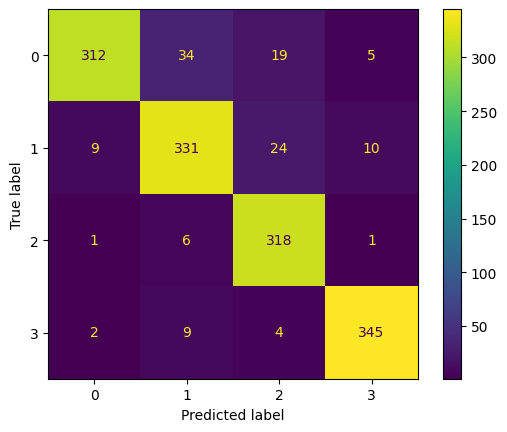

In [22]:
metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred_classes)

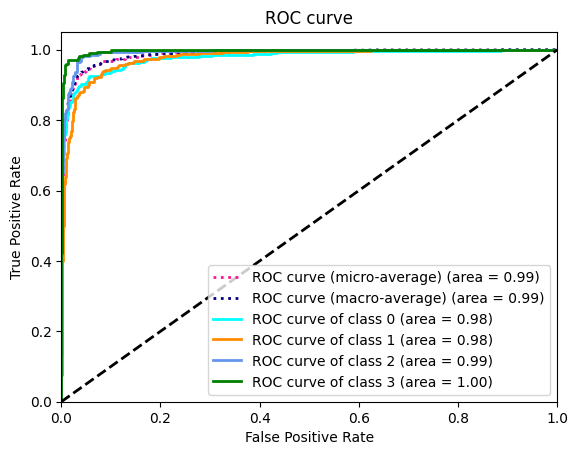

In [23]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from itertools import cycle



# Calcolare le curve ROC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = test_generator.num_classes

y_true_categorical = to_categorical(y_true, num_classes=n_classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_categorical[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcolare la media delle curve ROC micro e macro
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_categorical.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calcolare il valore medio delle AUC macro
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot della curva ROC per ogni classe
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='ROC curve (micro-average) (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)
plt.plot(fpr["macro"], tpr["macro"],
         label='ROC curve (macro-average) (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Plot della linea diagonale (classificatore casuale)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Impostare limiti e etichette del grafico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()


FIN QUI FUNZIONA

## TO DO

## VERSIONE VECCHIA

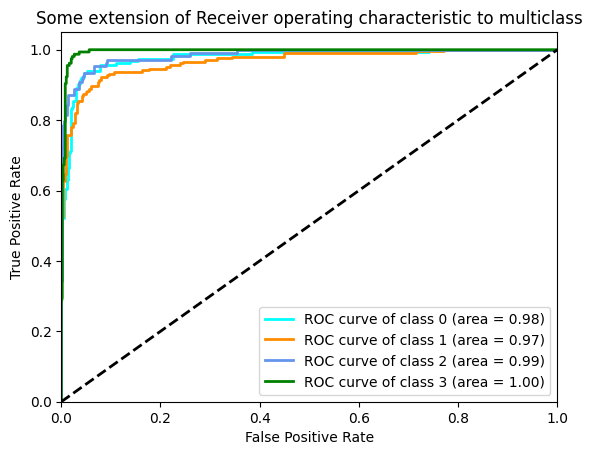

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(4), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multiclass')
plt.legend(loc='lower right')
plt.show()


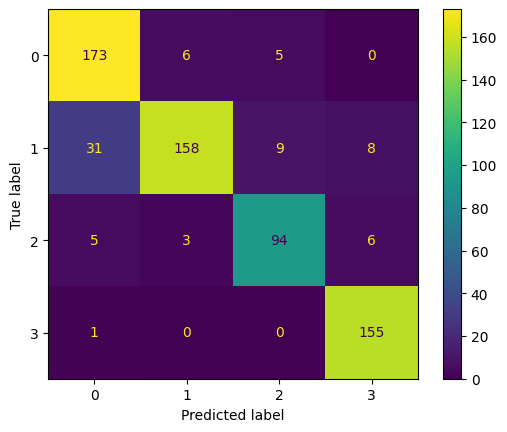

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['0', '1'])
disp.plot()
plt.show()

# classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

confonde meningioma con il glioma